In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward_propagation(self, input):
        pass

    def backward_propagation(self, output_error, learning_rate):
        pass

In [3]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5   #number of input and output neurons
        self.bias = np.random.rand(1, output_size) - 0.5
        
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T) 
        weights_error = np.dot(self.input.T, output_error)  

        # updating parameters
        self.weights -= learning_rate * weights_error       
        self.bias -= learning_rate * output_error
        return input_error

In [4]:
class ActivationLayer(Layer):
    def __init__(self, activation_func, activation_func_prime):
        self.activation = activation_func
        self.activation_prime = activation_func_prime

    def forward_propagation(self, data):
        self.input = data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [5]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return 1. * (x > 0)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def softmax_prime(x):
    return softmax(x) * (1 - softmax(x))


In [6]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

In [53]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        len_sam = len(input_data)
        result = []
        for i in range(len_sam):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result

    def fit(self, x_train, y_train, epochs, learning_rate, x_val, y_val):
        len_sam = len(x_train)
        error_train = []
        error_val = []
        # training loop
        for i in range(epochs):
            train_err = 0
            for j in range(len_sam):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                train_err += self.loss(y_train[j], output)
                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            train_err /= len_sam
            error_train.append(train_err)
            validation_err = self.loss(y_val, self.predict(x_val))
            error_val.append(validation_err)
            print('epoch: %d/%d   t_error: %f val_error: %f' % (i+1, epochs, train_err, validation_err))
        return error_train, error_val
    def fit_batch(self, x_train, y_train, epochs, learning_rate, x_val, y_val, batch_size):
        len_sam = len(x_train)
        error_train = []
        error_val = []
        # training loop
        for i in range(epochs):
            train_err = 0
            for j in range(len_sam//batch_size):
                # forward propagation
                output = x_train[j*batch_size:(j+1)*batch_size]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                train_err += self.loss(y_train[j*batch_size:(j+1)*batch_size], output)
                # backward propagation
                error = self.loss_prime(y_train[j*batch_size:(j+1)*batch_size], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            train_err /= len_sam
            error_train.append(train_err)
            validation_err = self.loss(y_val, self.predict(x_val))
            error_val.append(validation_err)
            print('epoch: %d/%d   t_error: %f val_error: %f' % (i+1, epochs, train_err, validation_err))
        return error_train, error_val        

In [8]:
#read housing data
data = pd.read_csv('housing.csv')

data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [10]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop('PRICE', axis=1), data['PRICE'], test_size=0.2, random_state=12345)

In [11]:
#split train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=12345)

In [12]:
X_train.shape


(363, 13)

In [13]:
X_train_np=np.array(X_train)
y_train_np=np.array(y_train)
X_train_nn=X_train_np.reshape(X_train.shape[0],1,13)
y_train_nn=y_train_np.reshape(y_train.shape[0],1,1)

X_val_np=np.array(X_val)
y_val_np=np.array(y_val)
X_val_nn=X_val_np.reshape(X_val.shape[0],1,13)
y_val_nn=y_val_np.reshape(y_val.shape[0],1,1)

X_test_np=np.array(X_test)
y_test_np=np.array(y_test)
X_test_nn=X_test_np.reshape(102,1,13)
y_test_nn=y_test_np.reshape(102,1,1)

In [37]:
#create the network with 0 hidden layers
network = NeuralNetwork()
network.add(Dense(13, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

#train the network
error_train_hid0, error_val_hid0 = network.fit(X_train_nn, y_train_nn, epochs=1000, learning_rate=0.000001, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
hid0_err=mse(y_val_nn, y_pred)
hid0_test_err=mse(y_test_nn, network.predict(X_test_nn))

epoch: 1/1000   t_error: 511.392114 val_error: 577.699564
epoch: 2/1000   t_error: 469.627808 val_error: 542.397887
epoch: 3/1000   t_error: 443.514985 val_error: 518.464955
epoch: 4/1000   t_error: 422.813887 val_error: 497.229449
epoch: 5/1000   t_error: 403.481078 val_error: 475.876546
epoch: 6/1000   t_error: 382.679203 val_error: 447.521929
epoch: 7/1000   t_error: 343.169318 val_error: 405.176812
epoch: 8/1000   t_error: 315.389106 val_error: 377.713166
epoch: 9/1000   t_error: 293.152655 val_error: 359.089395
epoch: 10/1000   t_error: 275.077391 val_error: 337.393368
epoch: 11/1000   t_error: 256.872085 val_error: 320.181587
epoch: 12/1000   t_error: 242.096915 val_error: 304.957984
epoch: 13/1000   t_error: 229.298126 val_error: 290.147905
epoch: 14/1000   t_error: 216.978558 val_error: 277.256531
epoch: 15/1000   t_error: 205.761198 val_error: 265.670136
epoch: 16/1000   t_error: 195.387975 val_error: 254.712979
epoch: 17/1000   t_error: 185.424971 val_error: 243.518881
epoch:

In [38]:
#create the network with 1 hidden layers,
#with 10 neurons in the hidden layer
network = NeuralNetwork()
network.add(Dense(13, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

#train the network
error_train_hid1, error_val_hid1 = network.fit(X_train_nn, y_train_nn, epochs=1000, learning_rate=0.000001, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
hid1_err=mse(y_val_nn, y_pred)
hid1_test_err=mse(y_test_nn, network.predict(X_test_nn))

epoch: 1/1000   t_error: 548.450270 val_error: 597.256713
epoch: 2/1000   t_error: 465.429432 val_error: 515.668495
epoch: 3/1000   t_error: 403.995170 val_error: 465.366682
epoch: 4/1000   t_error: 364.060910 val_error: 429.670700
epoch: 5/1000   t_error: 331.226558 val_error: 396.454871
epoch: 6/1000   t_error: 301.735202 val_error: 365.697084
epoch: 7/1000   t_error: 276.643588 val_error: 339.805950
epoch: 8/1000   t_error: 254.897274 val_error: 317.704846
epoch: 9/1000   t_error: 235.741424 val_error: 297.832450
epoch: 10/1000   t_error: 218.753919 val_error: 280.007650
epoch: 11/1000   t_error: 203.837305 val_error: 264.324165
epoch: 12/1000   t_error: 190.681925 val_error: 250.291546
epoch: 13/1000   t_error: 179.029835 val_error: 237.896758
epoch: 14/1000   t_error: 168.724133 val_error: 226.667176
epoch: 15/1000   t_error: 159.594054 val_error: 216.373712
epoch: 16/1000   t_error: 151.323719 val_error: 207.471483
epoch: 17/1000   t_error: 144.097674 val_error: 199.423914
epoch:

In [49]:
#create the network with 2 hidden layers,
#with 10 neurons in the hidden layer
network = NeuralNetwork()
network.add(Dense(13, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 64))
network.add(ActivationLayer(relu, relu_prime))
network.add(Dense(64, 64))
network.add(ActivationLayer(softmax, tanh_prime))
network.add(Dense(64, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

#train the network
error_train_hid2, error_val_hid2 = network.fit(X_train_nn, y_train_nn, epochs=1000, learning_rate=0.000005, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
hid2_err=mse(y_val_nn, y_pred)
hid2_test_err=mse(y_test_nn, network.predict(X_test_nn))


epoch: 1/1000   t_error: 585.126537 val_error: 677.102270
epoch: 2/1000   t_error: 582.001573 val_error: 673.837216
epoch: 3/1000   t_error: 578.287408 val_error: 668.545302
epoch: 4/1000   t_error: 572.817349 val_error: 662.574722
epoch: 5/1000   t_error: 567.164393 val_error: 656.684989
epoch: 6/1000   t_error: 561.684610 val_error: 650.834872
epoch: 7/1000   t_error: 556.141265 val_error: 644.874325
epoch: 8/1000   t_error: 550.535259 val_error: 639.034464
epoch: 9/1000   t_error: 545.151636 val_error: 633.437250
epoch: 10/1000   t_error: 540.075347 val_error: 628.287719
epoch: 11/1000   t_error: 535.212072 val_error: 622.917029
epoch: 12/1000   t_error: 530.143778 val_error: 617.509972
epoch: 13/1000   t_error: 525.069824 val_error: 612.129845
epoch: 14/1000   t_error: 520.053691 val_error: 606.811998
epoch: 15/1000   t_error: 515.086699 val_error: 601.570782
epoch: 16/1000   t_error: 510.205383 val_error: 596.409074
epoch: 17/1000   t_error: 505.403299 val_error: 591.324660
epoch:

In [50]:
#print hid0,hid1 and hid2 test error
print('Test error for 0 hidden layers: ', hid0_test_err)
print('Test error for 1 hidden layers: ', hid1_test_err)
print('Test error for 2 hidden layers: ', hid2_test_err)

Test error for 0 hidden layers:  48.03714666338828
Test error for 1 hidden layers:  51.036587707055624
Test error for 2 hidden layers:  53.6234609974278


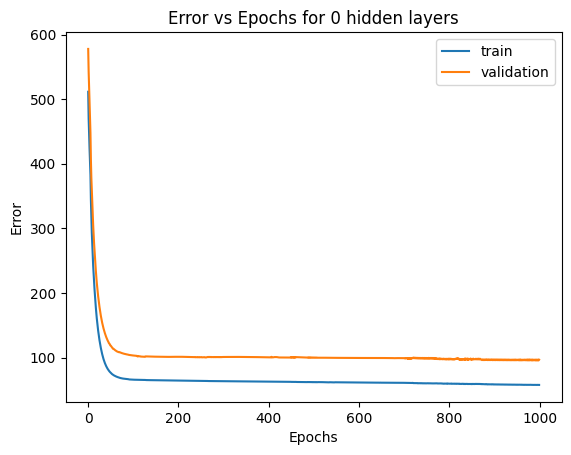

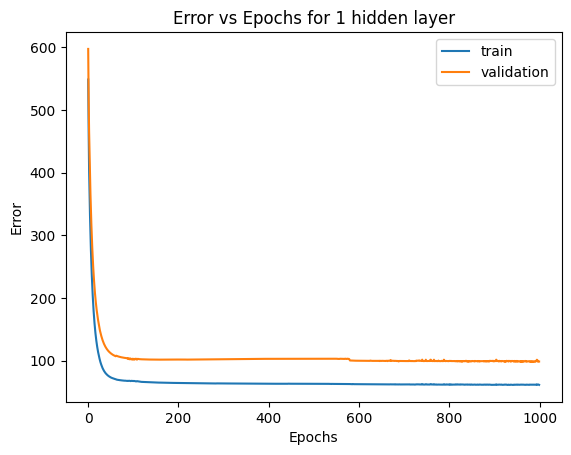

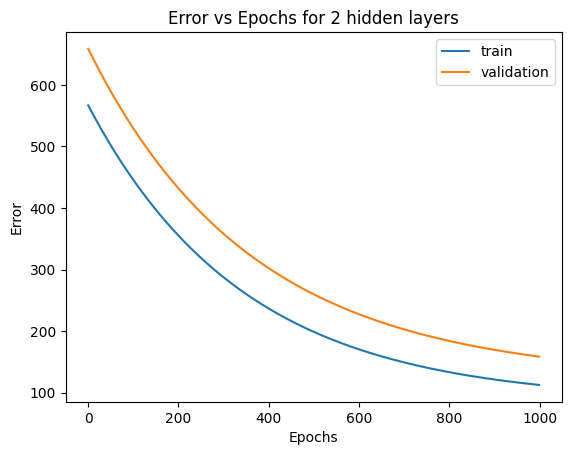

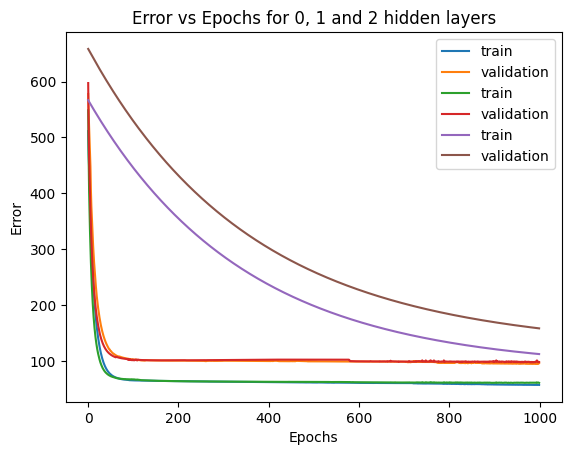

In [44]:
#plot the error vs epochs
plt.plot(error_train_hid0, label='train')
plt.plot(error_val_hid0, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for 0 hidden layers')
plt.show()

#plot the error vs epochs
plt.plot(error_train_hid1, label='train')
plt.plot(error_val_hid1, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for 1 hidden layer')
plt.show()

#plot the error vs epochs
plt.plot(error_train_hid2, label='train')
plt.plot(error_val_hid2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for 2 hidden layers')
plt.show()

#merge all plots
plt.plot(error_train_hid0, label='train')
plt.plot(error_val_hid0, label='validation')
plt.plot(error_train_hid1, label='train')
plt.plot(error_val_hid1, label='validation')
plt.plot(error_train_hid2, label='train')
plt.plot(error_val_hid2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for 0, 1 and 2 hidden layers')
plt.show()

In [63]:
network = NeuralNetwork()
network.add(Dense(13, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 64))
network.add(ActivationLayer(relu, relu_prime))
network.add(Dense(64, 64))
network.add(ActivationLayer(softmax, tanh_prime))
network.add(Dense(64, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

error_train_n0, error_val_n0 = network.fit(X_train_nn, y_train_nn, epochs=670, learning_rate=0.000007, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
n0_err=mse(y_val_nn, y_pred)
n0_test_err=mse(y_test_nn, network.predict(X_test_nn))

epoch: 1/670   t_error: 587.102054 val_error: 681.875972
epoch: 2/670   t_error: 586.181810 val_error: 675.287802
epoch: 3/670   t_error: 578.004829 val_error: 666.021542
epoch: 4/670   t_error: 570.080419 val_error: 659.799227
epoch: 5/670   t_error: 564.489655 val_error: 653.777974
epoch: 6/670   t_error: 558.883748 val_error: 648.328729
epoch: 7/670   t_error: 553.567285 val_error: 641.831898
epoch: 8/670   t_error: 547.236666 val_error: 634.996799
epoch: 9/670   t_error: 540.901178 val_error: 628.293210
epoch: 10/670   t_error: 534.622289 val_error: 621.680636
epoch: 11/670   t_error: 528.492406 val_error: 615.228664
epoch: 12/670   t_error: 522.675536 val_error: 609.690882
epoch: 13/670   t_error: 517.471616 val_error: 603.501464
epoch: 14/670   t_error: 511.459702 val_error: 596.813317
epoch: 15/670   t_error: 505.264075 val_error: 590.429601
epoch: 16/670   t_error: 499.287317 val_error: 584.009577
epoch: 17/670   t_error: 493.179270 val_error: 577.492876
epoch: 18/670   t_error

In [64]:
network = NeuralNetwork()
network.add(Dense(13, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 64))
network.add(ActivationLayer(relu, relu_prime))
network.add(Dense(64, 32))
network.add(ActivationLayer(softmax, tanh_prime))
network.add(Dense(32, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

error_train_n1, error_val_n1 = network.fit(X_train_nn, y_train_nn, epochs=670, learning_rate=0.000007, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
n1_err=mse(y_val_nn, y_pred)
n1_test_err=mse(y_test_nn, network.predict(X_test_nn))

epoch: 1/670   t_error: 552.124965 val_error: 637.144745
epoch: 2/670   t_error: 544.393885 val_error: 631.969898
epoch: 3/670   t_error: 539.695960 val_error: 625.084058
epoch: 4/670   t_error: 533.521647 val_error: 618.252527
epoch: 5/670   t_error: 526.658412 val_error: 611.528446
epoch: 6/670   t_error: 522.573264 val_error: 606.206664
epoch: 7/670   t_error: 516.127338 val_error: 599.809475
epoch: 8/670   t_error: 509.363951 val_error: 592.870975
epoch: 9/670   t_error: 502.770902 val_error: 586.277954
epoch: 10/670   t_error: 496.275051 val_error: 579.411234
epoch: 11/670   t_error: 489.771805 val_error: 572.513064
epoch: 12/670   t_error: 483.011171 val_error: 560.919767
epoch: 13/670   t_error: 468.479428 val_error: 548.023355
epoch: 14/670   t_error: 459.010769 val_error: 537.229054
epoch: 15/670   t_error: 448.703437 val_error: 529.643494
epoch: 16/670   t_error: 441.309040 val_error: 521.511915
epoch: 17/670   t_error: 434.088870 val_error: 514.036100
epoch: 18/670   t_error

In [67]:
network = NeuralNetwork()
network.add(Dense(13, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 128))
network.add(ActivationLayer(relu, relu_prime))
network.add(Dense(128, 64))
network.add(ActivationLayer(softmax, tanh_prime))
network.add(Dense(64, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

error_train_n2, error_val_n2 = network.fit(X_train_nn, y_train_nn, epochs=670, learning_rate=0.000007, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
n2_err=mse(y_val_nn, y_pred)
n2_test_err=mse(y_test_nn, network.predict(X_test_nn))

epoch: 1/670   t_error: 564.201433 val_error: 651.234712
epoch: 2/670   t_error: 555.508332 val_error: 640.875009
epoch: 3/670   t_error: 545.838917 val_error: 631.328260
epoch: 4/670   t_error: 537.295614 val_error: 623.752274
epoch: 5/670   t_error: 530.264173 val_error: 616.349407
epoch: 6/670   t_error: 523.338755 val_error: 608.965265
epoch: 7/670   t_error: 516.551975 val_error: 601.780439
epoch: 8/670   t_error: 509.851536 val_error: 594.518209
epoch: 9/670   t_error: 503.139258 val_error: 587.475529
epoch: 10/670   t_error: 496.535946 val_error: 580.510664
epoch: 11/670   t_error: 490.028778 val_error: 573.625531
epoch: 12/670   t_error: 483.605521 val_error: 566.831669
epoch: 13/670   t_error: 477.276824 val_error: 560.129297
epoch: 14/670   t_error: 471.041979 val_error: 553.518568
epoch: 15/670   t_error: 464.906095 val_error: 547.004970
epoch: 16/670   t_error: 458.888514 val_error: 540.594386
epoch: 17/670   t_error: 452.920510 val_error: 534.284905
epoch: 18/670   t_error

In [61]:
#print n0,n1 and n2 test error
print('Test error for constant neuron: ', n0_test_err)
print('Test error for decreasing neuron: ', n1_test_err)
print('Test error for increasing and decreasing neuron: ', n2_test_err)

Test error for constant neuron:  53.24140957337004
Test error for decreasing neuron:  61.003128638408555
Test error for increasing and decreasing neuron:  59.05032049617868


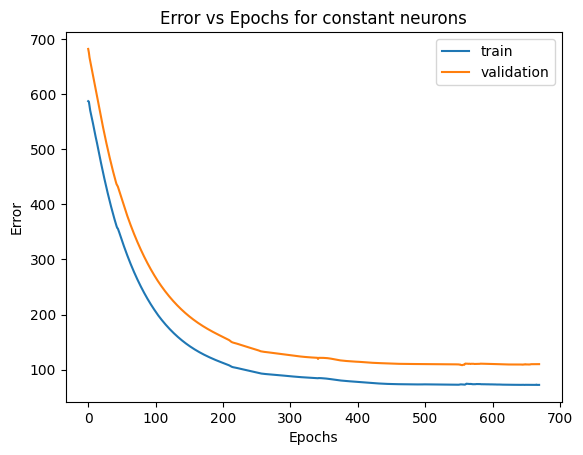

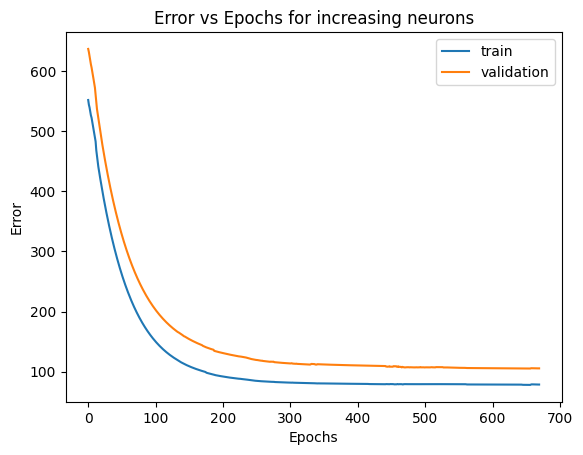

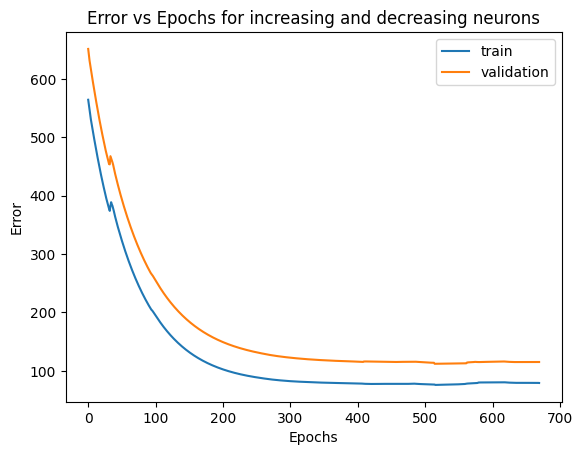

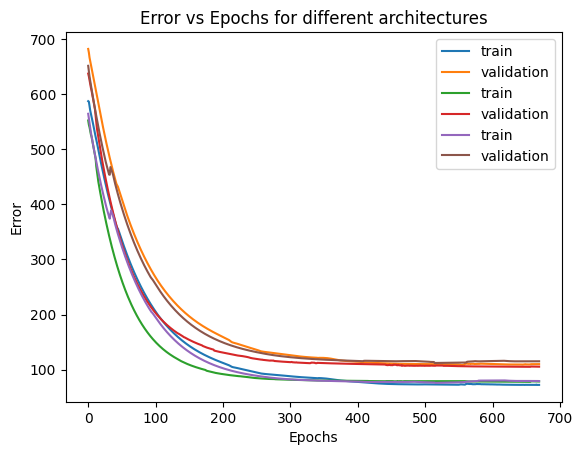

In [68]:
#plot the error vs epochs
plt.plot(error_train_n0, label='train')
plt.plot(error_val_n0, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for constant neurons')
plt.show()

#plot the error vs epochs
plt.plot(error_train_n1, label='train')
plt.plot(error_val_n1, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for increasing neurons')
plt.show()

#plot the error vs epochs
plt.plot(error_train_n2, label='train')
plt.plot(error_val_n2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for increasing and decreasing neurons')
plt.show()


#merge all plots
plt.plot(error_train_n0, label='train')
plt.plot(error_val_n0, label='validation')
plt.plot(error_train_n1, label='train')
plt.plot(error_val_n1, label='validation')
plt.plot(error_train_n2, label='train')
plt.plot(error_val_n2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for different architectures')
plt.show()

In [22]:
import time

In [23]:
network = NeuralNetwork()
network.add(Dense(13, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)


#train the network
error_train_lr0, error_val_lr0 = network.fit(X_train_nn, y_train_nn, epochs=700, learning_rate=0.0000001, x_val=X_val_nn, y_val=y_val_nn)


#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
lr1_err=mse(y_val_nn, y_pred)

epoch 1/700   error=539.574810
epoch 2/700   error=520.904855
epoch 3/700   error=499.724928
epoch 4/700   error=479.293536
epoch 5/700   error=461.337392
epoch 6/700   error=440.851914
epoch 7/700   error=423.462282
epoch 8/700   error=406.041626
epoch 9/700   error=392.576991
epoch 10/700   error=380.613305
epoch 11/700   error=369.841417
epoch 12/700   error=359.852683
epoch 13/700   error=350.960686
epoch 14/700   error=342.714395
epoch 15/700   error=334.435220
epoch 16/700   error=325.890650
epoch 17/700   error=317.155699
epoch 18/700   error=309.660196
epoch 19/700   error=302.518199
epoch 20/700   error=295.297387
epoch 21/700   error=287.498972
epoch 22/700   error=280.993188
epoch 23/700   error=274.818149
epoch 24/700   error=268.014410
epoch 25/700   error=261.239821
epoch 26/700   error=255.078702
epoch 27/700   error=249.404787
epoch 28/700   error=243.990937
epoch 29/700   error=238.712810
epoch 30/700   error=233.349825
epoch 31/700   error=228.450873
epoch 32/700   er

In [24]:
network = NeuralNetwork()
network.add(Dense(13, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)


#train the network
error_train_lr1, error_val_lr1 = network.fit(X_train_nn, y_train_nn, epochs=700, learning_rate=0.0000005, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
lr1_err=mse(y_val_nn, y_pred)

epoch 1/700   error=582.329619
epoch 2/700   error=576.172880
epoch 3/700   error=573.138737
epoch 4/700   error=570.385621
epoch 5/700   error=567.727567
epoch 6/700   error=564.705964
epoch 7/700   error=559.081351
epoch 8/700   error=551.012587
epoch 9/700   error=535.857653
epoch 10/700   error=475.319828
epoch 11/700   error=394.345177
epoch 12/700   error=345.910072
epoch 13/700   error=310.812146
epoch 14/700   error=281.741692
epoch 15/700   error=255.812265
epoch 16/700   error=234.871906
epoch 17/700   error=216.343024
epoch 18/700   error=199.436031
epoch 19/700   error=184.238763
epoch 20/700   error=170.485159
epoch 21/700   error=158.543185
epoch 22/700   error=148.673126
epoch 23/700   error=140.150702
epoch 24/700   error=132.561112
epoch 25/700   error=125.882675
epoch 26/700   error=120.007919
epoch 27/700   error=114.722511
epoch 28/700   error=109.997295
epoch 29/700   error=105.814011
epoch 30/700   error=102.064382
epoch 31/700   error=98.793376
epoch 32/700   err

In [25]:
network = NeuralNetwork()
network.add(Dense(13, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)

#train the network

error_train_lr2, error_val_lr2 = network.fit(X_train_nn, y_train_nn, epochs=700, learning_rate=0.000001, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
lr2_err=mse(y_val_nn, y_pred)

epoch 1/700   error=532.250308
epoch 2/700   error=375.952876
epoch 3/700   error=281.562314
epoch 4/700   error=230.212759
epoch 5/700   error=195.915140
epoch 6/700   error=171.073004
epoch 7/700   error=151.964633
epoch 8/700   error=136.228919
epoch 9/700   error=123.324334
epoch 10/700   error=112.992104
epoch 11/700   error=104.103809
epoch 12/700   error=97.629129
epoch 13/700   error=91.633525
epoch 14/700   error=86.247082
epoch 15/700   error=82.581810
epoch 16/700   error=79.772069
epoch 17/700   error=77.378743
epoch 18/700   error=75.429593
epoch 19/700   error=73.857118
epoch 20/700   error=72.566060
epoch 21/700   error=71.473505
epoch 22/700   error=70.799664
epoch 23/700   error=69.886105
epoch 24/700   error=69.548495
epoch 25/700   error=68.654020
epoch 26/700   error=68.267488
epoch 27/700   error=67.487245
epoch 28/700   error=67.143097
epoch 29/700   error=66.837385
epoch 30/700   error=66.457557
epoch 31/700   error=65.885617
epoch 32/700   error=65.845747
epoch 

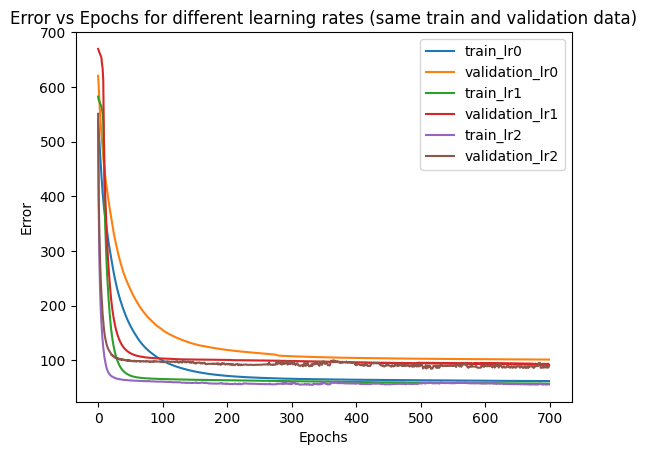

In [26]:
#plot the error vs epochs
#show all error for different learning rates on same plot
plt.plot(error_train_lr0, label='train_lr0')
plt.plot(error_val_lr0, label='validation_lr0')
plt.plot(error_train_lr1, label='train_lr1')
plt.plot(error_val_lr1, label='validation_lr1')
plt.plot(error_train_lr2, label='train_lr2')
plt.plot(error_val_lr2, label='validation_lr2')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for different learning rates (same train and validation data)')
plt.show()


In [27]:
network = NeuralNetwork()
network.add(Dense(13, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 256))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(256, 128))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(128, 64))
network.add(ActivationLayer(tanh, tanh_prime))
network.add(Dense(64, 1))
network.add(ActivationLayer(relu, relu_prime))
network.use(mse, mse_prime)


#train the network
error_train_epoch, error_val_epoch = network.fit(X_train_nn, y_train_nn, epochs=3000, learning_rate=0.0000001, x_val=X_val_nn, y_val=y_val_nn)

#predict the output
y_pred = network.predict(X_val_nn)

#calculate the mean squared error
epoch_err=mse(y_val_nn, y_pred)

epoch 1/3000   error=558.676896
epoch 2/3000   error=532.031790
epoch 3/3000   error=505.943209
epoch 4/3000   error=485.286093
epoch 5/3000   error=471.205558
epoch 6/3000   error=458.533731
epoch 7/3000   error=447.419731
epoch 8/3000   error=436.391989
epoch 9/3000   error=424.904552
epoch 10/3000   error=413.481463
epoch 11/3000   error=404.515104
epoch 12/3000   error=395.913058
epoch 13/3000   error=387.455666
epoch 14/3000   error=379.488707
epoch 15/3000   error=372.912027
epoch 16/3000   error=366.169305
epoch 17/3000   error=360.358098
epoch 18/3000   error=354.797250
epoch 19/3000   error=348.588739
epoch 20/3000   error=343.053104
epoch 21/3000   error=336.841842
epoch 22/3000   error=330.228068
epoch 23/3000   error=323.731057
epoch 24/3000   error=318.828723
epoch 25/3000   error=314.489024
epoch 26/3000   error=310.037555
epoch 27/3000   error=306.258316
epoch 28/3000   error=302.342792
epoch 29/3000   error=298.510272
epoch 30/3000   error=294.806248
epoch 31/3000   err

Text(0.5, 1.0, 'Error vs Epochs for increasing epochs')

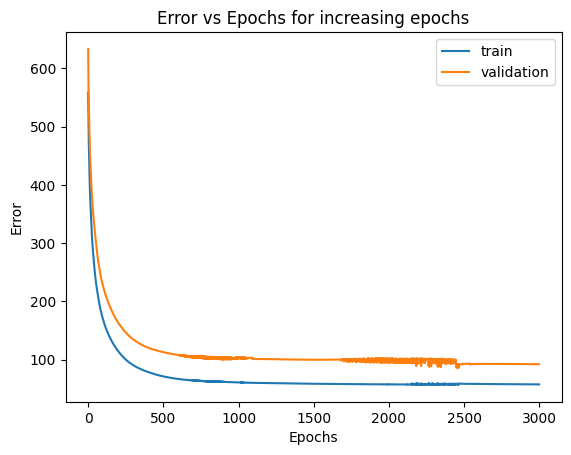

In [28]:
#plot error vs epochs
plt.plot(error_train_epoch, label='train')
plt.plot(error_val_epoch, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error vs Epochs for increasing epochs')

In [90]:
best_network = NeuralNetwork()
best_network.add(Dense(13, 128))
best_network.add(ActivationLayer(sigmoid, sigmoid_prime))
best_network.add(Dense(128, 32))
best_network.add(ActivationLayer(relu, relu_prime))
best_network.add(Dense(32, 1))
best_network.add(ActivationLayer(relu, relu_prime))
best_network.use(mse, mse_prime)


#train the network
error_train_best, error_val_best = best_network.fit(X_train_nn, y_train_nn, epochs=1000, learning_rate=0.000001, x_val=X_val_nn, y_val=y_val_nn)


#calculate test error
y_pred_test = best_network.predict(X_test_nn)
test_err=mse(y_test_nn, y_pred_test)
test_err

epoch: 1/1000   t_error: 589.211312 val_error: 681.993760
epoch: 2/1000   t_error: 587.828692 val_error: 679.063924
epoch: 3/1000   t_error: 577.267021 val_error: 656.713649
epoch: 4/1000   t_error: 536.798996 val_error: 595.356380
epoch: 5/1000   t_error: 475.436108 val_error: 532.777031
epoch: 6/1000   t_error: 415.787669 val_error: 469.335155
epoch: 7/1000   t_error: 358.776297 val_error: 411.949966
epoch: 8/1000   t_error: 304.266758 val_error: 352.124131
epoch: 9/1000   t_error: 251.663797 val_error: 299.181379
epoch: 10/1000   t_error: 207.703908 val_error: 255.482695
epoch: 11/1000   t_error: 170.838681 val_error: 217.634573
epoch: 12/1000   t_error: 140.725893 val_error: 187.054006
epoch: 13/1000   t_error: 118.130461 val_error: 162.382041
epoch: 14/1000   t_error: 101.764009 val_error: 144.617172
epoch: 15/1000   t_error: 90.151613 val_error: 132.446670
epoch: 16/1000   t_error: 82.620948 val_error: 124.186332
epoch: 17/1000   t_error: 77.605186 val_error: 118.432397
epoch: 18

34.01211261788601